In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, transforms, datasets, models
import torchvision.transforms as transforms
!pip install ultralytics
from ultralytics import YOLO
from PIL import Image
from sklearn.metrics import confusion_matrix
import csv
!pip install timm
import timm
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 14.3 MB/s eta 0:00:00a 0:00:01


***CONSTANTS***

In [2]:
train_dir = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
num_classes = 65
image_shape = (224, 224)

***PREPROCESSING***

In [3]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset = MakeDataset(train_dir, transform=transform)

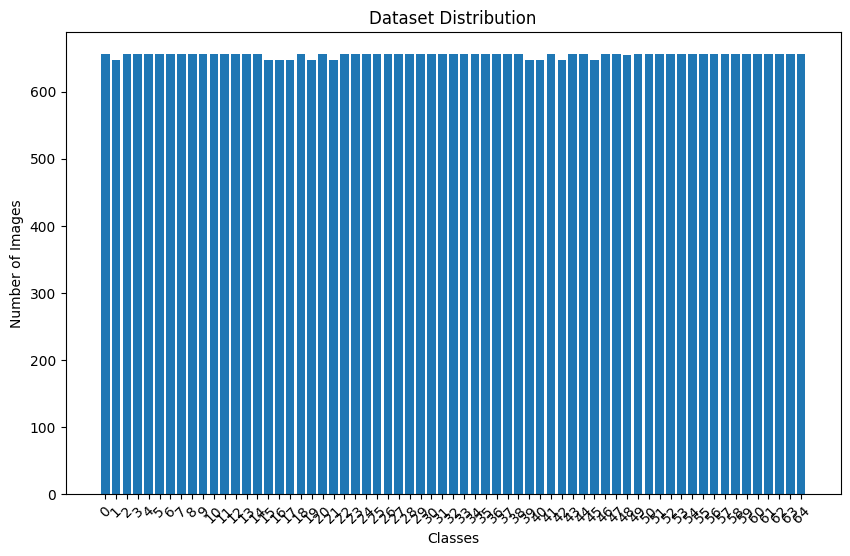

Minimum three letters based on the number of images:
1 648
15 648
16 648
17 648
19 648
21 648
39 648
40 648
42 648
45 648
48 655
0 656
2 656
3 656
4 656
5 656
6 656
7 656
8 656
9 656
10 656
11 656
12 656
13 656
14 656
18 656
20 656
22 656
23 656
24 656
25 656
26 656
27 656
28 656
29 656
30 656
31 656
32 656
33 656
34 656
35 656
36 656
37 656
38 656
41 656
43 656
44 656
46 656
47 656
49 656
50 656
51 656
52 656
53 656
54 656
55 656
56 656
57 656
58 656
59 656
60 656
61 656
62 656
63 656
64 656


In [6]:
class_counts = {cls: 0 for cls in dataset.classes}
for _, label in dataset.images:
    class_counts[dataset.classes[label]] += 1

# Plot the dataset distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(rotation=45)
plt.show()

# Find the minimum three letters based on the number of images
min_three_letters = sorted(dataset.class_to_idx, key=lambda x: class_counts[x])

print("Minimum three letters based on the number of images:")
for letter in min_three_letters:
    print(letter, class_counts[letter])

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 8

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def show_images(images, labels, ncols=8):
    figure, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f'Class: {labels[i]}')
        ax.axis('off')

In [11]:
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

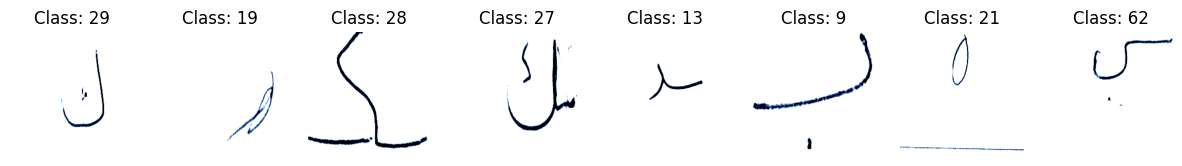

In [12]:
show_images(images, labels)
plt.show()

In [13]:
#Final Delivery (Running with squeeze and excitation blocks)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class InceptionWithSE(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionWithSE, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(True),
            SEBlock(ch1x1)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(True),
            SEBlock(ch3x3)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(True),
            SEBlock(ch5x5)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
            SEBlock(pool_proj)
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

class GoogLeNetSE(nn.Module):
    def __init__(self, num_classes=65):
        super(GoogLeNetSE, self).__init__()
        self.base_model = models.googlenet(pretrained=True, transform_input=False)

        # Replace each Inception module with one that includes SE blocks
        self.base_model.inception3a = InceptionWithSE(192, 64, 96, 128, 16, 32, 32)
        self.base_model.inception3b = InceptionWithSE(256, 128, 128, 192, 32, 96, 64)
        self.base_model.inception4a = InceptionWithSE(480, 192, 96, 208, 16, 48, 64)
        self.base_model.inception4b = InceptionWithSE(512, 160, 112, 224, 24, 64, 64)
        self.base_model.inception4c = InceptionWithSE(512, 128, 128, 256, 24, 64, 64)
        self.base_model.inception4d = InceptionWithSE(512, 112, 144, 288, 32, 64, 64)
        self.base_model.inception4e = InceptionWithSE(528, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5a = InceptionWithSE(832, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5b = InceptionWithSE(832, 384, 192, 384, 48, 128, 128)

        # Replaceing the last fully connected layer to match the number of classes
        self.base_model.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [14]:
device1 = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device2 = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device3 = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [16]:
#Original Model
googlenett = models.googlenet(pretrained=True)
googlenett.fc = nn.Linear(googlenett.fc.in_features, 65)
googlenett = googlenett.to(device1)

optimizer = torch.optim.Adam(googlenett.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [18]:
#Final Delivery (Running with Swin Transformer Base Patch 4, Window 7)
swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=65)
swin_transformer = swin_transformer.to(device2)

optimizer = torch.optim.Adam(swin_transformer.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [19]:
#Final Delivery (Running with squeeze and excitation blocks)
googlenet_se = GoogLeNetSE(num_classes=65).to(device3)

optimizer = torch.optim.Adam(googlenet_se.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [20]:
# List of true labels and their corresponding predicted labels
true_labels = [64, 42, 37, 64, 14, 24, 64, 64, 40, 9, 14, 41, 57, 56, 54, 49, 58, 11, 13, 46, 47, 2, 57, 3, 37, 57, 11, 57, 17, 39, 46, 43, 57, 18, 59, 37, 45, 57, 35, 26, 45, 18, 64, 16, 53, 58, 64, 57, 57, 18, 64, 16, 57, 35, 45, 43, 57, 9, 57, 23, 0, 64, 36, 15, 23, 2, 7, 57, 57, 13, 53, 57, 58, 13, 15, 57, 28, 0, 9, 57, 57, 7, 2, 14, 37, 10, 57, 14, 52, 16, 25, 57, 34, 15, 18, 31, 16, 57, 22, 37, 57, 53, 27, 18, 37, 59, 58, 47, 14, 53, 23, 33, 57, 13, 51, 57, 63, 57, 57, 47, 57, 35, 21, 8, 57, 64, 46, 57, 53, 42, 15, 14, 64, 64, 57, 57, 57, 1, 13, 10, 2, 9, 14, 1, 17, 57, 15, 57, 56, 18, 4, 43, 52, 55, 57, 24, 47, 43, 11, 57, 43, 18, 18, 15, 6, 8, 64, 56, 13, 42, 15, 40, 57, 34, 37, 57, 64, 64, 44, 39, 0, 57, 37, 43, 17, 44, 43, 14, 57, 14, 59, 57, 64, 37, 64, 23, 35, 64, 19, 15, 47, 57, 23, 17, 42, 57, 57, 64, 36, 23, 45, 54, 13, 45, 11, 31, 53, 58, 64, 16, 11, 14, 29, 64, 29, 57, 6, 64, 57, 57, 46, 37, 31, 14, 43, 13, 36, 64, 42, 56, 51, 11, 18, 20, 15, 23, 17, 44, 16, 37, 64, 64, 57, 27, 1, 37, 42, 14, 51, 37, 18, 17, 37, 18, 46, 4, 14, 18, 13, 16, 57, 57, 43, 19, 11, 46, 56, 64, 57, 22, 18, 48, 23, 34, 32, 13, 14, 15]

predicted_labels = [26, 60, 50, 62, 31, 22, 62, 26, 17, 61, 34, 39, 56, 57, 52, 50, 56, 10, 33, 13, 14, 60, 56, 5, 35, 56, 10, 56, 16, 41, 26, 50, 56, 16, 60, 49, 43, 56, 48, 2, 18, 15, 26, 43, 54, 15, 62, 56, 56, 15, 26, 17, 56, 48, 36, 44, 56, 61, 56, 25, 50, 26, 38, 18, 24, 35, 8, 56, 56, 32, 55, 56, 21, 24, 18, 56, 13, 59, 12, 56, 56, 8, 60, 34, 50, 11, 56, 14, 54, 17, 10, 56, 41, 18, 15, 31, 17, 56, 12, 4, 56, 54, 1, 45, 4, 4, 56, 31, 15, 41, 16, 15, 5, 7, 62, 57, 33, 18, 40, 27, 56, 29, 50, 57, 18, 15, 32, 17, 56, 56, 49, 48, 10, 41, 57, 51, 56, 62, 56, 24, 15, 3, 25, 31, 33, 40, 31, 47, 14, 1, 33, 38, 62, 42, 57, 56, 22, 15, 51, 25, 34, 33, 40, 31, 18, 20, 60, 25, 16, 37, 62, 62, 56, 44, 41, 50, 42, 31, 47, 1, 33, 38, 62, 42, 56, 57, 17, 16, 4, 15, 13, 32, 17]

# Count occurrences of each pair (true_label, predicted_label)
label_pairs = list(zip(true_labels, predicted_labels))
label_counts = {}
for pair in label_pairs:
    if pair in label_counts:
        label_counts[pair] += 1
    else:
        label_counts[pair] = 1

# Create a 65x65 matrix initialized with zeros
num_classes = 65
noise_transition_matrix = np.zeros((num_classes, num_classes))

# Fill in the matrix with the normalized counts
for i in range(num_classes):
    for j in range(num_classes):
        count = label_counts.get((i, j), 0)
        total_count = sum([value for key, value in label_counts.items() if key[0] == i])
        if total_count > 0:
            noise_transition_matrix[i, j] = count / total_count

In [23]:
noise_transition_matrix = torch.tensor(noise_transition_matrix).float().to(device1)

In [27]:
torch.cuda.empty_cache()

In [21]:
num_epochs = 10
desired_training_accuracy = 99.999
early_stopping_threshold = 5  
early_stopping_counter = 0
best_val_loss = float('inf')

In [22]:
# Lists to store training and validation metrics for plotting curves
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

**Load Weights to Model Directly**

In [23]:
googlenett.load_state_dict(torch.load("/kaggle/input/googlnett-weights/googlenett_weights.pth"))
swin_transformer.load_state_dict(torch.load("/kaggle/input/swin-weights/swin_transformer_weights.pth"))
googlenet_se.load_state_dict(torch.load("/kaggle/input/googlenetse-weight/googlenet_se_weights.pth"))

<All keys matched successfully>

**Save Predictions**

In [26]:
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        
        inputs, labels = inputs.to(device2), labels.to(device2)
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        
        inputs, labels = inputs.to(device3), labels.to(device3)

        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [27]:
y_pred1

[6,
 29,
 55,
 36,
 14,
 19,
 63,
 3,
 35,
 33,
 45,
 29,
 33,
 9,
 61,
 57,
 49,
 25,
 50,
 11,
 8,
 25,
 24,
 32,
 53,
 54,
 17,
 50,
 18,
 33,
 48,
 6,
 24,
 32,
 30,
 16,
 25,
 36,
 39,
 29,
 55,
 14,
 12,
 0,
 34,
 26,
 11,
 24,
 27,
 63,
 56,
 27,
 35,
 35,
 25,
 18,
 58,
 15,
 36,
 16,
 14,
 59,
 13,
 54,
 44,
 5,
 43,
 9,
 37,
 2,
 25,
 8,
 52,
 61,
 23,
 59,
 32,
 6,
 49,
 57,
 8,
 29,
 13,
 14,
 39,
 52,
 16,
 44,
 24,
 62,
 21,
 5,
 64,
 11,
 25,
 39,
 9,
 22,
 50,
 36,
 3,
 8,
 24,
 17,
 22,
 59,
 41,
 38,
 45,
 53,
 55,
 47,
 50,
 9,
 39,
 56,
 36,
 3,
 55,
 25,
 14,
 46,
 62,
 61,
 1,
 43,
 39,
 9,
 44,
 39,
 51,
 63,
 6,
 6,
 37,
 9,
 58,
 61,
 40,
 47,
 33,
 50,
 12,
 55,
 1,
 53,
 36,
 14,
 37,
 64,
 58,
 35,
 39,
 56,
 63,
 57,
 17,
 34,
 38,
 49,
 39,
 43,
 19,
 64,
 61,
 25,
 2,
 46,
 47,
 13,
 47,
 27,
 17,
 3,
 61,
 16,
 37,
 11,
 32,
 19,
 42,
 47,
 21,
 13,
 1,
 41,
 16,
 56,
 12,
 3,
 22,
 21,
 52,
 13,
 63,
 64,
 6,
 53,
 26,
 13,
 31,
 59,
 34,
 15,
 0,
 3,
 

In [28]:
y_pred2

[6,
 29,
 55,
 36,
 14,
 19,
 63,
 3,
 35,
 33,
 45,
 29,
 33,
 9,
 61,
 57,
 49,
 25,
 50,
 11,
 8,
 25,
 24,
 32,
 53,
 54,
 17,
 50,
 18,
 33,
 48,
 6,
 24,
 32,
 30,
 16,
 25,
 36,
 39,
 29,
 55,
 14,
 12,
 0,
 34,
 26,
 11,
 24,
 27,
 63,
 56,
 27,
 35,
 35,
 25,
 18,
 58,
 15,
 36,
 16,
 14,
 59,
 13,
 54,
 44,
 5,
 43,
 9,
 37,
 2,
 25,
 8,
 52,
 61,
 23,
 59,
 32,
 6,
 49,
 57,
 8,
 29,
 13,
 14,
 39,
 52,
 16,
 44,
 24,
 62,
 21,
 5,
 64,
 11,
 25,
 39,
 9,
 22,
 50,
 36,
 3,
 8,
 24,
 17,
 22,
 60,
 41,
 38,
 45,
 53,
 55,
 47,
 50,
 9,
 39,
 56,
 36,
 3,
 55,
 25,
 14,
 46,
 62,
 61,
 1,
 43,
 39,
 9,
 44,
 39,
 51,
 63,
 6,
 6,
 37,
 9,
 58,
 61,
 40,
 47,
 33,
 50,
 12,
 55,
 1,
 53,
 36,
 14,
 37,
 64,
 58,
 35,
 39,
 56,
 63,
 56,
 44,
 34,
 38,
 49,
 39,
 43,
 19,
 64,
 61,
 25,
 2,
 46,
 47,
 13,
 47,
 27,
 17,
 3,
 61,
 16,
 37,
 11,
 32,
 19,
 42,
 47,
 21,
 13,
 1,
 41,
 16,
 56,
 12,
 3,
 22,
 21,
 52,
 13,
 63,
 64,
 6,
 53,
 26,
 13,
 31,
 59,
 34,
 15,
 0,
 3,
 

In [29]:
y_pred3

[6,
 29,
 55,
 36,
 31,
 19,
 63,
 3,
 35,
 33,
 45,
 29,
 33,
 9,
 61,
 57,
 49,
 25,
 50,
 11,
 8,
 25,
 24,
 32,
 53,
 54,
 17,
 4,
 18,
 33,
 48,
 6,
 24,
 32,
 30,
 16,
 25,
 36,
 39,
 29,
 55,
 31,
 12,
 0,
 34,
 26,
 11,
 24,
 27,
 63,
 56,
 27,
 35,
 35,
 25,
 16,
 58,
 15,
 36,
 16,
 14,
 59,
 13,
 54,
 44,
 5,
 43,
 9,
 37,
 2,
 25,
 8,
 52,
 61,
 23,
 59,
 32,
 6,
 49,
 57,
 8,
 29,
 33,
 14,
 39,
 52,
 16,
 44,
 24,
 62,
 21,
 5,
 64,
 11,
 25,
 39,
 9,
 22,
 50,
 36,
 3,
 8,
 24,
 17,
 22,
 59,
 41,
 38,
 45,
 53,
 55,
 47,
 50,
 12,
 39,
 56,
 36,
 3,
 55,
 25,
 14,
 46,
 62,
 61,
 1,
 43,
 39,
 9,
 44,
 39,
 51,
 63,
 6,
 6,
 37,
 9,
 58,
 61,
 40,
 47,
 33,
 50,
 12,
 55,
 1,
 53,
 36,
 14,
 37,
 64,
 58,
 35,
 39,
 56,
 63,
 56,
 17,
 34,
 38,
 49,
 39,
 43,
 19,
 64,
 61,
 25,
 2,
 46,
 47,
 13,
 47,
 27,
 17,
 3,
 61,
 16,
 37,
 11,
 32,
 19,
 42,
 47,
 21,
 13,
 1,
 41,
 16,
 56,
 12,
 3,
 22,
 21,
 52,
 13,
 63,
 64,
 6,
 53,
 26,
 46,
 31,
 59,
 34,
 15,
 0,
 3,
 

**Ensemble Classifier**

In [30]:
def vote(finall):
    """
    Perform a vote on each element of the given lists.
    In case of a tie, the value from the first list is chosen.
    
    Returns:
    - List containing the voted values.
    """
    result = []
    list_len = len(finall[0])

    for i in range(list_len):
        # Count occurrences of each element in the current position
        counts = {}
        for lst in finall:
            value = lst[i]
            counts[value] = counts.get(value, 0) + 1
        
        # Find the element with the maximum count
        max_count = max(counts.values())
        candidates = [key for key, count in counts.items() if count == max_count]
        
        # Choose the winner, or use the value from the first list in case of a tie
        winner = candidates[0] if len(candidates) == 1 else finall[0][i]
        result.append(winner)

    return result

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions)

[6, 29, 55, 36, 14, 19, 63, 3, 35, 33, 45, 29, 33, 9, 61, 57, 49, 25, 50, 11, 8, 25, 24, 32, 53, 54, 17, 50, 18, 33, 48, 6, 24, 32, 30, 16, 25, 36, 39, 29, 55, 14, 12, 0, 34, 26, 11, 24, 27, 63, 56, 27, 35, 35, 25, 18, 58, 15, 36, 16, 14, 59, 13, 54, 44, 5, 43, 9, 37, 2, 25, 8, 52, 61, 23, 59, 32, 6, 49, 57, 8, 29, 13, 14, 39, 52, 16, 44, 24, 62, 21, 5, 64, 11, 25, 39, 9, 22, 50, 36, 3, 8, 24, 17, 22, 59, 41, 38, 45, 53, 55, 47, 50, 9, 39, 56, 36, 3, 55, 25, 14, 46, 62, 61, 1, 43, 39, 9, 44, 39, 51, 63, 6, 6, 37, 9, 58, 61, 40, 47, 33, 50, 12, 55, 1, 53, 36, 14, 37, 64, 58, 35, 39, 56, 63, 56, 17, 34, 38, 49, 39, 43, 19, 64, 61, 25, 2, 46, 47, 13, 47, 27, 17, 3, 61, 16, 37, 11, 32, 19, 42, 47, 21, 13, 1, 41, 16, 56, 12, 3, 22, 21, 52, 13, 63, 64, 6, 53, 26, 13, 31, 59, 34, 15, 0, 3, 46, 29, 55, 64, 29, 0, 56, 15, 0, 56, 52, 44, 12, 40, 15, 31, 25, 35, 20, 28, 41, 11, 40, 37, 12, 31, 38, 34, 26, 5, 45, 49, 0, 49, 10, 23, 50, 1, 10, 50, 44, 31, 23, 7, 62, 6, 27, 47, 12, 63, 27, 6, 8, 15,

In [31]:
len(ensemble_predictions)

4257

In [32]:
accuracy_score(y_true, ensemble_predictions)

0.9931876908621095

**Calculate Stats**

Weighted Precision: 99.33232294388293
Weighted Recall: 99.31876908621095
Weighted F1 Score: 99.31912808076333
Unweighted Precision: 99.32496400563642
Unweighted Recall: 99.3268611052734
Unweighted F1 Score: 99.31944466346708


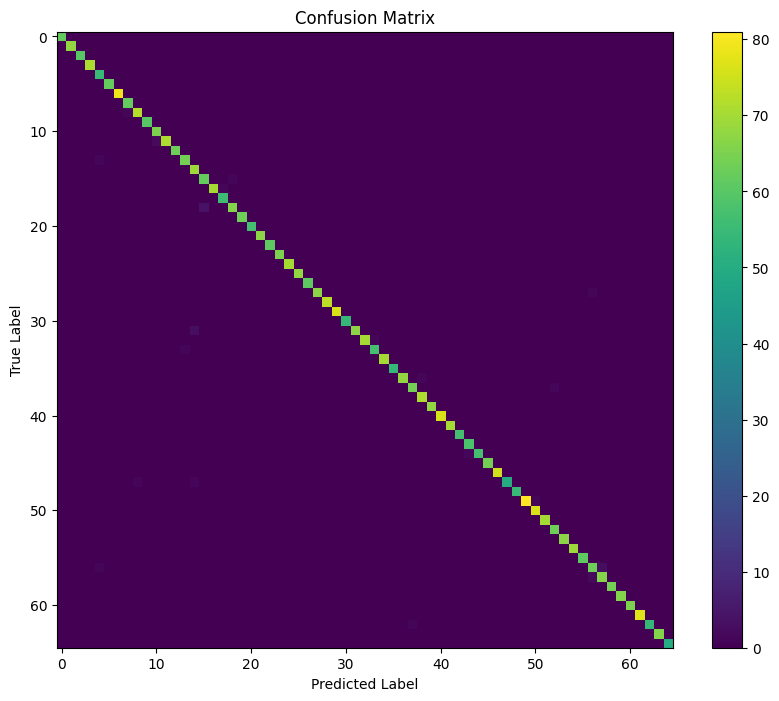

In [34]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, ensemble_predictions, average='weighted')
unweighted_precision, unweighted_recall, unweighted_f1_score, _ = precision_recall_fscore_support(y_true, ensemble_predictions, average='macro')

print("Weighted Precision:", precision * 100)
print("Weighted Recall:", recall * 100)
print("Weighted F1 Score:", f1_score * 100)
print("Unweighted Precision:", unweighted_precision * 100)
print("Unweighted Recall:", unweighted_recall * 100)
print("Unweighted F1 Score:", unweighted_f1_score * 100)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, ensemble_predictions)

# Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()